# How to map faults in 3-D seismic reflection data

This tutorial describes how to map tectonic faults in 3-D seismic reflection data using a convolutional neural network.

## Setup ##

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-3/tutorial-3.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. Before running anything in here, you need to tell Colab that ^would like to use a GPU (important to train our models quickly). This is done by clicking on the ‘Runtime’ tab, selecting ‘Change runtime type’, changing hardware accelerator to ´GPU´ and clicking ´save´. Excellent! Colab is now set up!
6. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
7. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.


## Pre-processing ##
Now that everything is set up, we want to load our data, but first we need to load a couple of useful python packages:


In [ ]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow import keras

and clone our git repository:

In [ ]:
!git clone https://github.com/thilowrona/seismic_deep_learning

Cloning into 'seismic_deep_learning'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 637 (delta 47), reused 22 (delta 6), pack-reused 533
Receiving objects: 100% (637/637), 34.58 MiB | 36.06 MiB/s, done.
Resolving deltas: 100% (310/310), done.


Now we want to load a 3-D seismic volume onto our virtual machine. There are a couple public datasets available, for example at [https://terranubis.com/datalist/free](https://terranubis.com/datalist/free).

Let's say we want to use the F3 dataset from the Netherlands: [https://terranubis.com/datainfo/F3-Demo-2020](https://terranubis.com/datainfo/F3-Demo-2020). You can download this dataset onto our virtual machine like this (this taks a bit):


In [ ]:
!pip install googledrivedownloader

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='196UkQqciaAkS9P78lbIPr39Qf_DvlcBN',
                                    dest_path='./Seismic_data.sgy',
                                    unzip=False)

Now we install and load [segpy](https://github.com/sixty-north/segpy), a package to load seismic data (.sgy or .segy files):

In [ ]:
!pip install segpy

import segpy
from segpy.reader import create_reader

     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 112kB 36.6MB/s 


Next you can load (and scale) the F3 dataset:

In [ ]:
filename = "Seismic_data.sgy"
    
with open(filename, 'rb') as segy:
    segy_reader = segpy.reader.create_reader(segy)
    data = np.zeros((segy_reader.num_inlines(), segy_reader.num_trace_samples(1), segy_reader.num_xlines()))
    for inline_num, xline_num in segy_reader.inline_xline_numbers():
        trace_index = segy_reader.trace_index((inline_num, xline_num))        
        inline_start = segy_reader.inline_numbers()[0]
        xline_start  = segy_reader.xline_numbers()[0]        
        data[inline_num-inline_start,:,xline_num-xline_start] = segy_reader.trace_samples(trace_index)

data = (data-np.min(data))/(np.max(data)-np.min(data))

Now you can visualize a couple of inlines and look for geological structures that you would like to map:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

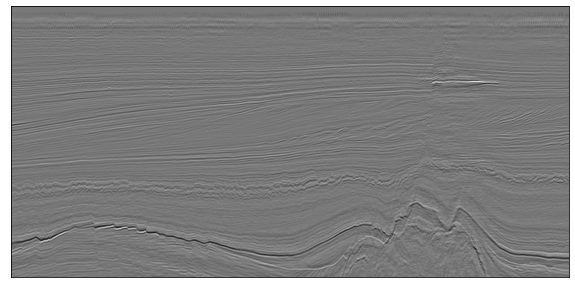

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

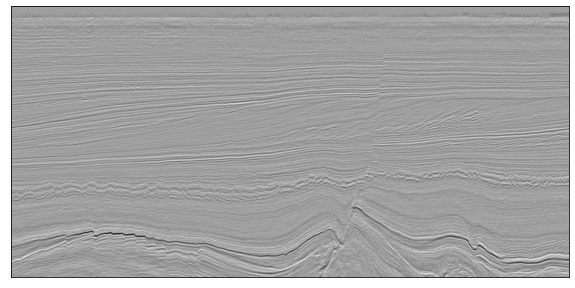

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

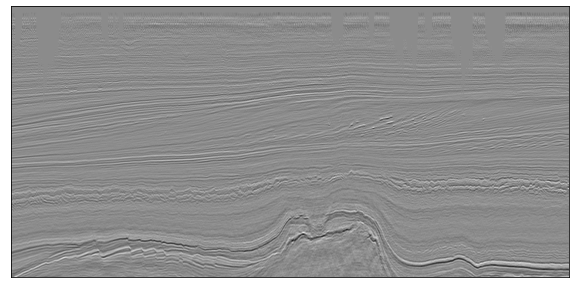

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

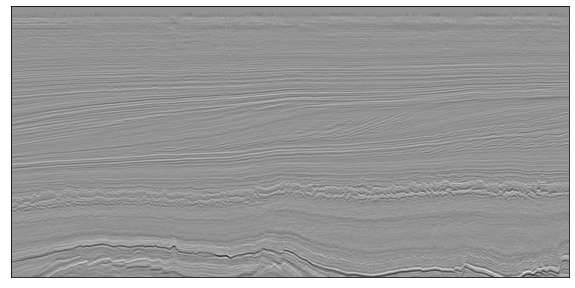

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

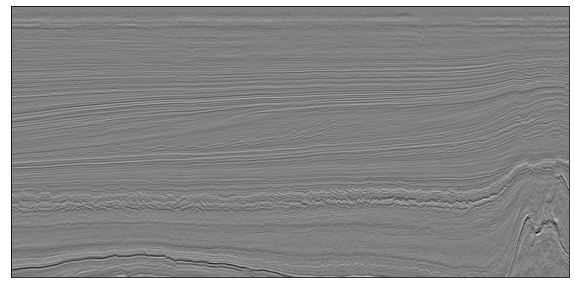

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
tb = widgets.TabBar([str(i) for i in range(100,501,100)])

for i in range(5): 
  with tb.output_to(i):
    plt.figure(figsize=(10,10))
    plt.imshow(data[100+100*i,:,:], cmap='gray')
    plt.xticks([])
    plt.yticks([])


Let's say you want to use deep learning to map all the faults in the data. To train a neural network, we need to label these faults in a couple of seismic sections. You can do this by exporting some of the images above and labelling these faults in Inkscape or Adobe Illustrator. This would look something like this:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

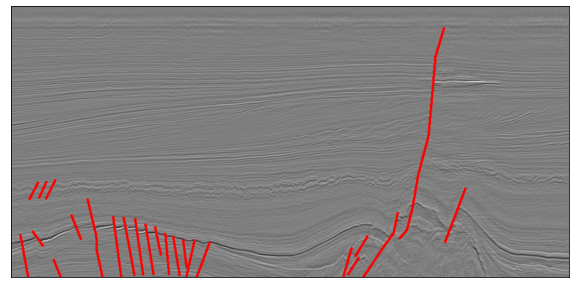

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

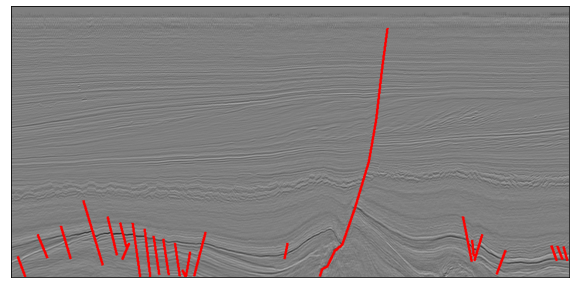

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

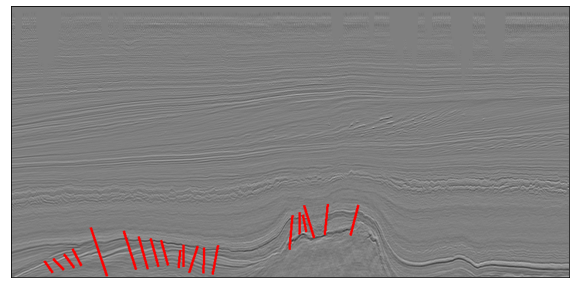

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

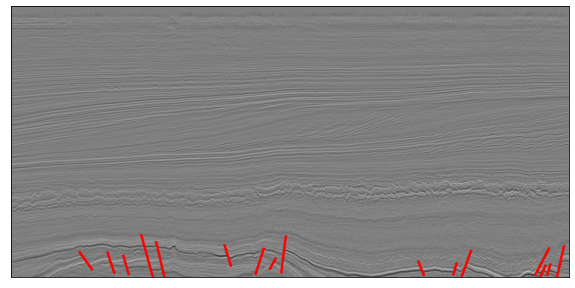

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

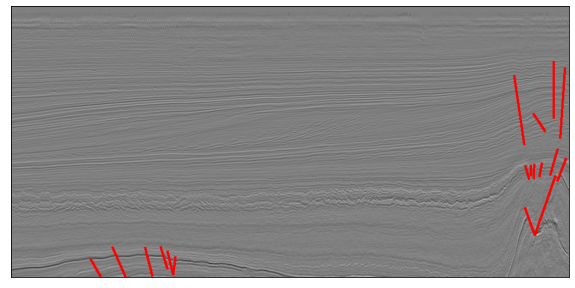

<IPython.core.display.Javascript object>

In [ ]:
def load_label(inline):
    label = Image.open('./seismic_deep_learning/tutorial-3/mask_inline_' + str(inline) + '.png')
    label.load()
    label = np.asarray(label)[:,:,3]
    label = np.where(label > 0.5, 1, 0)
    return label


def plot_overlay(image, label):
    (tmax, xmax) = np.shape(image)

    label_rgb = np.zeros((tmax,xmax,4), 'uint8')
    label_rgb[:,:,0] = 255
    label_rgb[:,:,1] = 255 - 255*label
    label_rgb[:,:,2] = 255 - 255*label
    label_rgb[:,:,3] = 255*label   
    
    img = Image.fromarray(label_rgb, mode='RGBA')
    
    image_rgb = np.zeros((tmax,xmax,4), 'uint8')    
    image_rgb[:,:,0] = 255*image
    image_rgb[:,:,1] = 255*image
    image_rgb[:,:,2] = 255*image
    image_rgb[:,:,3] = 255
    
    background = Image.fromarray(image_rgb, mode='RGBA')    
    background.paste(img, (0, 0), img)

    plt.imshow(background)
    plt.xticks([])
    plt.yticks([])



tb = widgets.TabBar([str(i) for i in range(100,501,100)])

for i in range(5): 
  with tb.output_to(i):
    plt.figure(figsize=(10,10))
    label = load_label(100+100*i)
    plot_overlay(data[100+100*i,:,:], label)
    plt.xticks([])
    plt.yticks([])

Now we can extract examples from our sections (seismic & label) to train our model:

In [ ]:
def patchify(data, label, size, number, threshold):

    (t_max, x_max) = label.shape    
    X = np.zeros((number, size, size, 1))
    Y = np.zeros((number, size, size, 1))
        
    n = 0
    while n < number: 
        x = random.randint(size//2, x_max-size//2)
        t = random.randint(size//2, t_max-size//2)
        if np.count_nonzero(label[t-size//2:t+size//2, x-size//2:x+size//2]) > threshold:
            X[n,:,:,0]  = data[t-size//2:t+size//2, x-size//2:x+size//2]
            Y[n,:,:,0]  = label[t-size//2:t+size//2, x-size//2:x+size//2]
            n = n + 1
    return X, Y


# Parameters
size       = 64
threshold  = 0
num_train  = 8000
num_val    = 2000


# Validation data from inline 300
X_val = np.zeros((num_val,size,size,1))
Y_val = np.zeros((num_val,size,size,1))

label   = load_label(300)
seismic = data[300,...]
X_val,Y_val = patchify(seismic, label, size, num_val, threshold)


# Training data from inlines 100, 200, 400, 500
X_train = np.zeros((num_train,size,size,1))
Y_train = np.zeros((num_train,size,size,1))
n = 0
for inline in [100, 200, 400, 500]:
  label   = load_label(inline)
  seismic = data[inline,...]
  X_train[n:n+num_train//4,...],Y_train[n:n+num_train//4,...] = patchify(seismic, label, size, num_train//4, threshold) 
  n += num_train//4

Before training, it's always a good idea to check the training data, so let's do that:

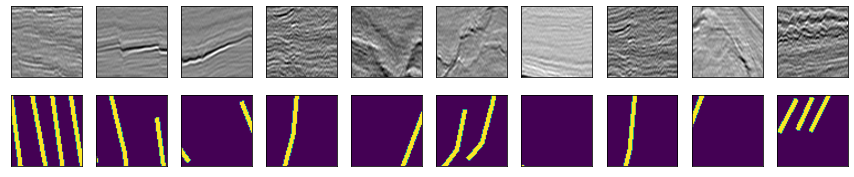

In [ ]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))

k = 0
for m in range(10):
  axs[0,m].imshow(X_train[k,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
  axs[0,m].set_xticks([])
  axs[0,m].set_yticks([])
  k += 1

k = 0
for m in range(10):
  axs[1,m].imshow(Y_train[k,:,:,0], interpolation='spline16', aspect=1)
  axs[1,m].set_xticks([])
  axs[1,m].set_yticks([])
  k += 1


What do you notice?

* Is it an easy task?
* Could you predict the masks?
* Can we learn more from some examples?

## Training ##
To train our model, we need to define its architecture. 



In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

  


def UNet():
  f = [16, 32, 64, 128, 256]
  inputs = tf.keras.layers.Input((size, size, 1))
  
  p0 = inputs
  c1, p1 = down_block(p0, f[0]) #128 -> 64
  c2, p2 = down_block(p1, f[1]) #64 -> 32
  c3, p3 = down_block(p2, f[2]) #32 -> 16
  c4, p4 = down_block(p3, f[3]) #16->8
  
  bn = bottleneck(p4, f[4])
  
  u1 = up_block(bn, c4, f[3]) #8 -> 16
  u2 = up_block(u1, c3, f[2]) #16 -> 32
  u3 = up_block(u2, c2, f[1]) #32 -> 64
  u4 = up_block(u3, c1, f[0]) #64 -> 128
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
  model = tf.keras.models.Model(inputs, outputs)
  return model




model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

Now you can train your convolutional neural net using the data generator:

In [ ]:
history = model.fit(X_train, 
                    Y_train, 
                    validation_data=(X_val, Y_val), 
                    epochs=5)

Epoch 1/5
250/250 [==============================] - 14s 23ms/step - loss: 0.2793 - acc: 0.9372 - val_loss: 0.2214 - val_acc: 0.9403
Epoch 2/5
250/250 [==============================] - 5s 21ms/step - loss: 0.2072 - acc: 0.9452 - val_loss: 0.2072 - val_acc: 0.9403
Epoch 3/5
250/250 [==============================] - 5s 21ms/step - loss: 0.1769 - acc: 0.9458 - val_loss: 0.2311 - val_acc: 0.9357
Epoch 4/5
250/250 [==============================] - 5s 21ms/step - loss: 0.0999 - acc: 0.9624 - val_loss: 0.2944 - val_acc: 0.9254
Epoch 5/5
250/250 [==============================] - 5s 22ms/step - loss: 0.0568 - acc: 0.9768 - val_loss: 0.3812 - val_acc: 0.9289


To visualize our training, you can plot learning curves:

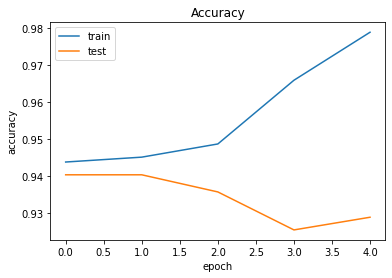

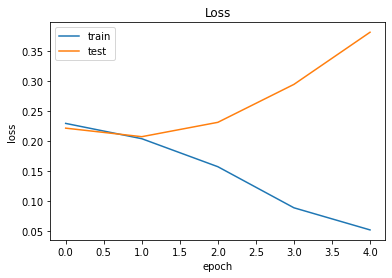

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

and a confusion matrix:

In [ ]:
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_val)
Y_true = Y_val    

cm = np.zeros((2,2))

for n in range(Y_true.shape[0]):

  y_true = Y_true[n,:,:,0].round().flatten()
  y_pred = Y_pred[n,:,:,0].round().flatten()

  cm_batch = confusion_matrix(y_true, y_pred)
              

  cm = cm + cm_batch

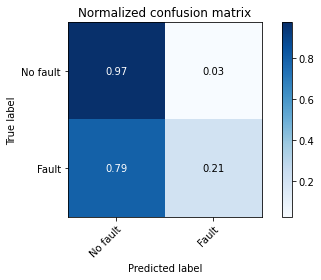

In [ ]:
cmap=plt.cm.Blues
normalize = True

title = 'Normalized confusion matrix'


# Only use the labels that appear in the data
classes = ['No fault','Fault']

# Normalize
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


fig, ax = plt.subplots()
im = ax.imshow(cm_norm, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm_norm.shape[1]),
       yticks=np.arange(cm_norm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title=title,
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' if normalize else 'd'
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, format(cm_norm[i, j], fmt),
                ha="center", va='center',
                color="white" if cm_norm[i, j] > thresh else "black")
fig.tight_layout()

##Application##
Now we can apply our model to the entire image to see how well it has learned to recognize salt structures in our seismic image:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

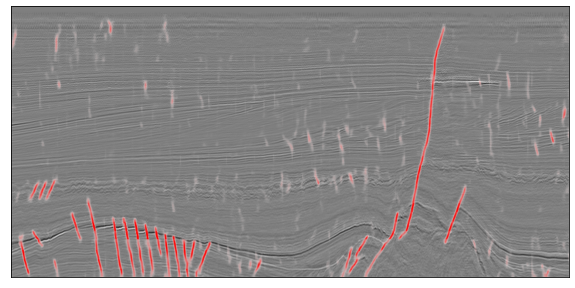

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

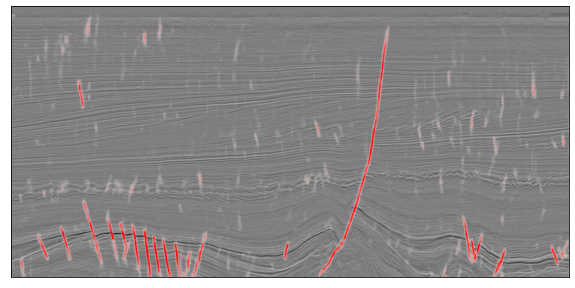

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

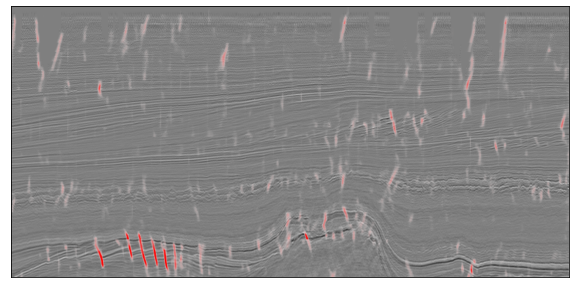

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

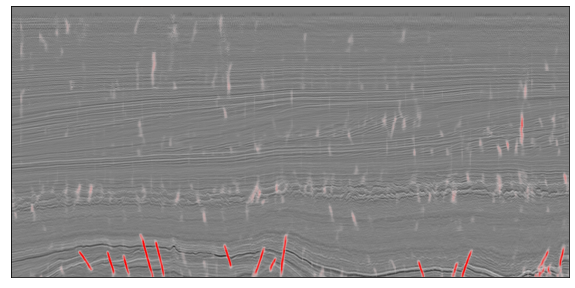

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

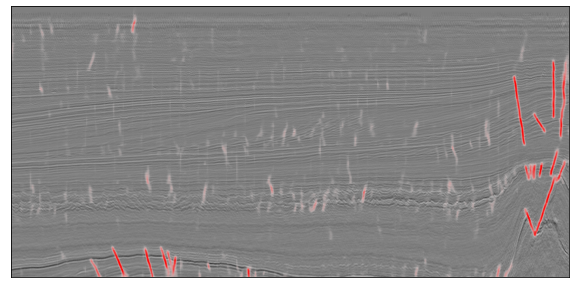

<IPython.core.display.Javascript object>

In [ ]:
def tile(data, wsize, dt, dx):
    
    (t_max, x_max) = data.shape    
    
    n_patch = (t_max//dt+1)*(x_max//dx+1)
    data_patch = np.zeros((n_patch,wsize,wsize,1)) 

    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):    
            if t_max - t < wsize and x_max - x < wsize:
                data_patch[n,:,:,0] = data[t_max-wsize:t_max, x_max-wsize:x_max]
            elif x_max - x < wsize:
                data_patch[n,:,:,0] = data[t:t+wsize, x_max-wsize:x_max]
            elif t_max - t < wsize:
                data_patch[n,:,:,0] = data[t_max-wsize:t_max, x:x+wsize]
            else:
                data_patch[n,:,:,0] = data[t:t+wsize,x:x+wsize]  
            n = n + 1
    
    return data_patch 




def merge(data_patch, t_max, x_max, wsize, dt, dx):

    data_new = np.zeros((t_max, x_max,1))
    count = np.zeros((t_max, x_max, 1))
    
    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):
            if t_max - t < wsize and x_max - x < wsize:
                data_new[t_max-wsize:t_max, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x_max-wsize:x_max,0] += 1
            elif x_max - x < wsize:
                data_new[t:t+wsize, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t:t+wsize, x_max-wsize:x_max,0] += 1 
            elif t_max - t < wsize:
                data_new[t_max-wsize:t_max, x:x+wsize,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x:x+wsize,0] += 1
            else:
                data_new[t:t+wsize,x:x+wsize,0] += data_patch[n,:,:,0]
                count[t:t+wsize,x:x+wsize,0] += 1 
            n = n + 1

    return data_new/count


dt = 16
dx = 16

(_, t_max, x_max) = data.shape



tb = widgets.TabBar([str(i) for i in range(100,501,100)])

for i in range(5): 
  with tb.output_to(i):
    plt.figure(figsize=(10,10))
    data_tiles   = tile(data[100+100*i,:,:], size, dt, dx)
    result_tiles = model.predict_on_batch(data_tiles)
    result       = merge(result_tiles, t_max, x_max, size, dt, dx)
    plot_overlay(data[100+100*i,:,:], result[:,:,0])
    plt.xticks([])
    plt.yticks([])

Not too bad for a first try! Check inline 300, which shows our predictions on a seismic line that it has not seen before. The model is able to find some of the clearer faults (bottom left) in the image. That's promising! Maybe we can even map these faults in a horizontal slice through the volume:

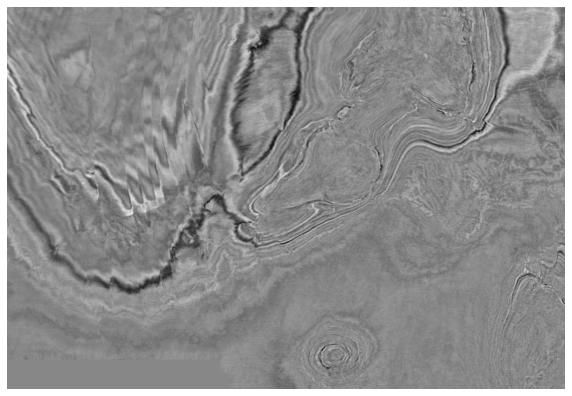

In [ ]:
depth = 420
time_slice = data[:,depth,:]

plt.figure(figsize=(10,10))
plt.imshow(time_slice, cmap= plt.cm.gray)
plt.axis('off')
plt.show()

Now let's predict! Again it will take a moment, since we have to process quite a bit of the volume

In [ ]:
(xmax, ymax) = time_slice.shape
nexp=(xmax-2*size)*(ymax-2*size)

batch_size = 1000

coord  = np.zeros((batch_size,2),int)
patch = np.zeros((batch_size,size,size,1))
prediction = np.zeros_like(time_slice)



m=0
n_batch = 0
for x in range(size,xmax-size):
        for y in range(size,ymax-size):
            patch[m,:,:,0] = data[x, depth-size//2:depth+size//2,y-size//2:y+size//2,]
            coord[m,:] = [x, y]                  
            m+=1        
            
            if m == batch_size:
                prediction[coord[:,0], coord[:,1]] = model.predict_on_batch(patch)[:,size//2,size//2,0]
                m=0
                
                print(str(n_batch+1) + ' of ' + str(round(nexp/batch_size)))
                n_batch += 1

1 of 430
2 of 430
3 of 430
4 of 430
5 of 430
6 of 430
7 of 430
8 of 430
9 of 430
10 of 430
11 of 430
12 of 430
13 of 430
14 of 430
15 of 430
16 of 430
17 of 430
18 of 430
19 of 430
20 of 430
21 of 430
22 of 430
23 of 430
24 of 430
25 of 430
26 of 430
27 of 430
28 of 430
29 of 430
30 of 430
31 of 430
32 of 430
33 of 430
34 of 430
35 of 430
36 of 430
37 of 430
38 of 430
39 of 430
40 of 430
41 of 430
42 of 430
43 of 430
44 of 430
45 of 430
46 of 430
47 of 430
48 of 430
49 of 430
50 of 430
51 of 430
52 of 430
53 of 430
54 of 430
55 of 430
56 of 430
57 of 430
58 of 430
59 of 430
60 of 430
61 of 430
62 of 430
63 of 430
64 of 430
65 of 430
66 of 430
67 of 430
68 of 430
69 of 430
70 of 430
71 of 430
72 of 430
73 of 430
74 of 430
75 of 430
76 of 430
77 of 430
78 of 430
79 of 430
80 of 430
81 of 430
82 of 430
83 of 430
84 of 430
85 of 430
86 of 430
87 of 430
88 of 430
89 of 430
90 of 430
91 of 430
92 of 430
93 of 430
94 of 430
95 of 430
96 of 430
97 of 430
98 of 430
99 of 430
100 of 430
101 of 4

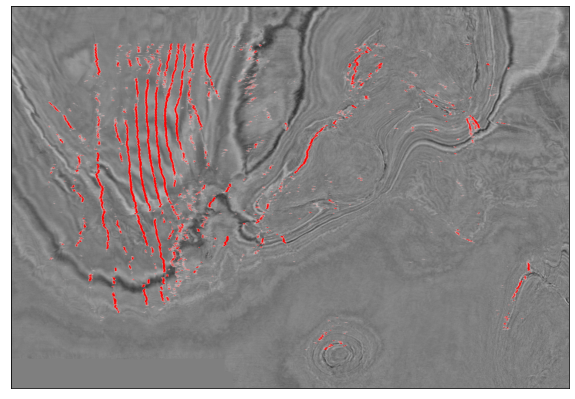

In [ ]:
plt.figure(figsize=(10,10))
plot_overlay(time_slice, prediction)

Awesome! The red lines are fault traces, so our model is able to map at least some these faults in 3-D.

Now that the basic workflow is running, we can think about improving our model... What would you do? Use a more complex model, more training examples or something else? Just try it out and compare your results

In the next tutorial ([tutorial-5](https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-5/tutorial_5.ipynb)), we will go from two to three dimensions using the same dataset to train a 3-D convolutional neural network with labels in 2-D. Check it out!